In [32]:
from langchain_groq import ChatGroq
from CONFIG import GROQ_MODEL, OPENAI_EMBEDDED_MODEL
from langchain_openai import OpenAIEmbeddings
from pydantic import BaseModel, Field
from typing import List, TypedDict, Literal
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langgraph.graph import START, END, StateGraph
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

In [33]:
load_dotenv()
llm = ChatGroq(model=GROQ_MODEL)
embedded_model = OpenAIEmbeddings(model=OPENAI_EMBEDDED_MODEL)

In [34]:
pdfs = (
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Company_Policies.pdf").load() + 
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Company_Profile.pdf").load() + 
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Products_and_Pricing.pdf").load()
)

In [35]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=60).split_documents(pdfs)
vector_store = FAISS.from_documents(splitter, embedded_model)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [86]:
class STATE(TypedDict):
    question: str
    retrieve_or_not: bool

    docs: List[Document]
    relevence_docs: List[Document]
    
    context: str
    answer: str

    issupp: Literal['fully_supported', 'partially_supported', 'no_support']
    evidence: List[str]

    retries: int

In [57]:
class should_retrive_or_not(BaseModel):
    retrieve_or_not: bool = Field(..., description="true if question needs document retrieval, false if answerable from general knowledge")

decision_prompt = ChatPromptTemplate.from_messages(
	[
	(
		"system",
		"You decide whether retrieval is needed.\n"
		"Return JSON that matches this schema:\n"
		"{{'retrieve_or_not': boolean}}\n\n"
		"Guidelines:\n"
		"- retrieve_or_not=True if answering requires specific facts, citations, or info likely not in the model.\n"
		"- retrieve_or_not=False for general explanations, definitions, or reasoning that doesn't need sources.\n"
		"- If unsure, choose True."
	),
	(
		"human",
		"user question is: {question}"
	)
	]
)

output = llm.with_structured_output(should_retrive_or_not)

def decision_node(state: 'STATE'):
	decision: should_retrive_or_not = output.invoke(decision_prompt.format_messages(question=state['question']))       
	return {'retrieve_or_not': decision.retrieve_or_not}

In [58]:
direct_generate_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer the question using only your general knowledge.\n"
            "Do NOT assume access to external documents.\n"
            "If you are unsure or the answer requires specific sources, say:\n"
            "I don't know based on my general knowledge. "
        ),
        ("human", "{question}")
    ]
)

def direct_generate(state: 'STATE'):
    answer = llm.invoke(direct_generate_prompt.format_messages(question=state['question']))
    return {"answer": answer.content}

In [59]:
def retriever_node(state: 'STATE'):
    return {'docs': retriever.invoke(state['question'])}

In [60]:
class relevent_document(BaseModel):
    relevent_or_not: bool = Field(
        ...,
        description="True if the document help answer to the question else False."
    )

relevence_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "you are judging document relevence.\n"
            "Return JSON that matchs this schema:\n"
            "{{'relevent_or_not': boolean}}\n\n"
            "A document is relevent if it contains information useful for asnwering the question."
        ),
        (
            "human",
            "question:\n{question}\n\nDocument:\n{document}" 
        )
    ]
)

relevence_llm = llm.with_structured_output(relevent_document)

def is_relevence(state: 'STATE'):
    relevent_docs: List[Document] = []
    for doc in state['docs']:
        decision: relevent_document = relevence_llm.invoke(
            relevence_prompt.format_messages(
                question=state['question'],
                document=doc.page_content
            )
        )
        if decision.relevent_or_not:
            relevent_docs.append(doc)
    
    return {'relevence_docs': relevent_docs}

In [61]:
relevent_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
		"You are a business RAG assistant.\n"
		"Answer the user's question using ONLY the provided context.\n"
		"If the context does not contain enough information, say:\n"
		"'No relevant document found.'\n"
		"Do not use outside knowledge.\n"
	  ),
	  (
		"human",
		"Documents are:\n{relevence_docs}\n\n"
		"Questions is:\n{question}"
	  )
    ]
)

def relevent_generation(state: 'STATE'):
    context = '\n\n---\n\n'.join(d.page_content for d in state.get('relevence_docs', [])).strip()
    if not context:
        return {'answer': 'No relevent document found', 'context': ''}
    rel_gen = llm.invoke(relevent_generation_prompt.format_messages(relevence_docs=context, question=state['question']))
    return {'answer': rel_gen.content, 'context': context}

def no_relevent_docs(state: 'STATE'):
    return {'answer': 'NO Relevent doc found', 'context': ''}

In [87]:
class IsSUPDecision(BaseModel):
    issupp: Literal['fully_supported', 'partially_supported', 'no_support']
    evidence: List[str]

IsSUPDecisionPrompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are verifying whether the ANSWER is supported by the CONTEXT.\n"
            "Return JSON with keys: issupp, evidence.\n"
            "issupp must be one of: fully_supported, partially_supported, no_support.\n\n"
            "How to decide issup:\n"
            "- fully_supported:\n"
            "  Every meaningful claim is explicitly supported by CONTEXT, and the ANSWER does NOT introduce\n"
            "  any qualitative/interpretive words that are not present in CONTEXT.\n"
            "  (Examples of disallowed words unless present in CONTEXT: culture, generous, robust, designed to,\n"
            "  supports professional development, best-in-class, employee-first, etc.)\n\n"
            "- partially_supported:\n"
            "  The core facts are supported, BUT the ANSWER includes ANY abstraction, interpretation, or qualitative\n"
            "  phrasing not explicitly stated in CONTEXT (e.g., calling policies 'culture', saying leave is 'generous',\n"
            "  or inferring outcomes like 'supports professional development').\n\n"
		"- no_support:\n"
		"  The key claims in the ANSWER are NOT found in CONTEXT at all, OR the ANSWER contradicts\n"
		"  information in CONTEXT, OR the ANSWER is based entirely on outside knowledge not present\n"
		"  in CONTEXT.\n"
		"  (Examples: stating a benefit that isn't mentioned, giving a wrong figure, answering from\n"
		"  general knowledge when CONTEXT has no relevant info.)\n\n"
            "Rules:\n"
            "- Be strict: if you see ANY unsupported qualitative/interpretive phrasing, choose partially_supported.\n"
            "- If the answer is mostly unrelated to the question or unsupported, choose no_support.\n"
            "- Evidence: include up to 3 short direct quotes from CONTEXT that support the supported parts.\n"
            "- Do not use outside knowledge."
	  ),
	  (
		"human",
            "Question:\n{question}\n\n"
            "Answer:\n{answer}\n\n"
            "Context:\n{context}\n"
	  )
    ]
)

issupllm = llm.with_structured_output(IsSUPDecision)

def IsSUPOrNot(state: 'STATE'):
    decision: IsSUPDecision = issupllm.invoke(
        IsSUPDecisionPrompt.format_messages(
            question=state['question'],
            answer=state.get('answer'),
            context=state.get('context')
	  )
    )

    return {
        'issupp': decision.issupp,
        'evidence': decision.evidence
    }


MAX_RETRIES = 10

def route_after_issup(state: 'STATE') -> Literal["accept_answer", "revise_answer"]:
    # accept if fully supported
    if state.get("issup") == "fully_supported":
        return "accept_answer"

    # stop if we've already tried enough
    if state.get("retries", 0) >= MAX_RETRIES:
        return "accept_answer"   # or return a "give_up" node if you want

    # otherwise revise again
    return "revise_answer"

In [63]:
def route_after_decision(state: STATE) -> Literal['direct_generate', 'retriever_node']:
    if state['retrieve_or_not']:
        return 'retriever_node'
    return 'direct_generate'

def route_after_relevence(state: 'STATE') -> Literal['relevent_generation', 'no_relevent_docs']:
    if state.get('relevence_docs') and len(state['relevence_docs']) > 0:
        return 'relevent_generation'
    return 'no_relevent_docs'

In [89]:
def accept_answer(state: STATE):
    return {}  # keep answer as-is

In [90]:
revise_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a STRICT reviser.\n\n"
            "You must output based on the following format:\n\n"
            "FORMAT (quote-only answer):\n"
            "- <direct quote from the CONTEXT>\n"
            "- <direct quote from the CONTEXT>\n\n"
            "Rules:\n"
            "- Use ONLY the CONTEXT.\n"
            "- Do NOT add any new words besides bullet dashes and the quotes themselves.\n"
            "- Do NOT explain anything.\n"
            "- Do NOT say 'context', 'not mentioned', 'does not mention', 'not provided', etc.\n"
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Current Answer:\n{answer}\n\n"
            "CONTEXT:\n{context}"
        ),
    ]
)

def revised_node(state: 'STATE'):
    decision = llm.invoke(
        revise_prompt.format_messages(
            question=state['question'],
            answer=state.get('answer', ''),
            context=state.get('context', '')
	  )
    )

    return {
        'answer': decision.content,
        'retries': state.get('retries', 0) + 1
        }

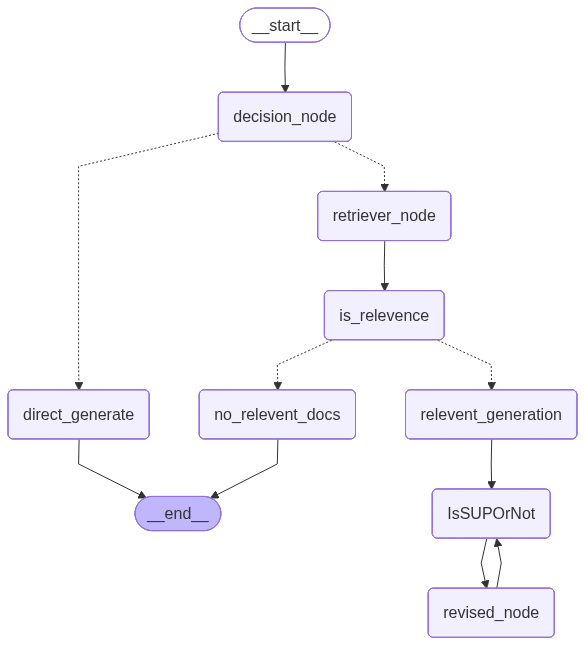

In [91]:
graph = StateGraph(STATE)

graph.add_node('decision_node', decision_node)
graph.add_node('retriever_node', retriever_node)
graph.add_node('direct_generate', direct_generate)
graph.add_node('is_relevence', is_relevence)
graph.add_node('relevent_generation', relevent_generation)
graph.add_node('no_relevent_docs', no_relevent_docs)
graph.add_node('IsSUPOrNot', IsSUPOrNot)
graph.add_node('revised_node', revised_node)

graph.add_edge(START, 'decision_node')
graph.add_conditional_edges(
    'decision_node',
    route_after_decision,
    {
        'retriever_node': 'retriever_node',
        'direct_generate': 'direct_generate'
    }
)

graph.add_edge("retriever_node", "is_relevence")

graph.add_conditional_edges(
    'is_relevence',
    route_after_relevence,
    {
        'relevent_generation': 'relevent_generation',
        'no_relevent_docs': 'no_relevent_docs'
    }
)
graph.add_edge("no_relevent_docs", END)
graph.add_edge("direct_generate", END)
graph.add_edge("relevent_generation", 'IsSUPOrNot')
graph.add_edge('IsSUPOrNot', 'revised_node')
graph.add_edge('revised_node', 'IsSUPOrNot')
graph.add_edge('IsSUPOrNot', END)

gra = graph.compile()
gra

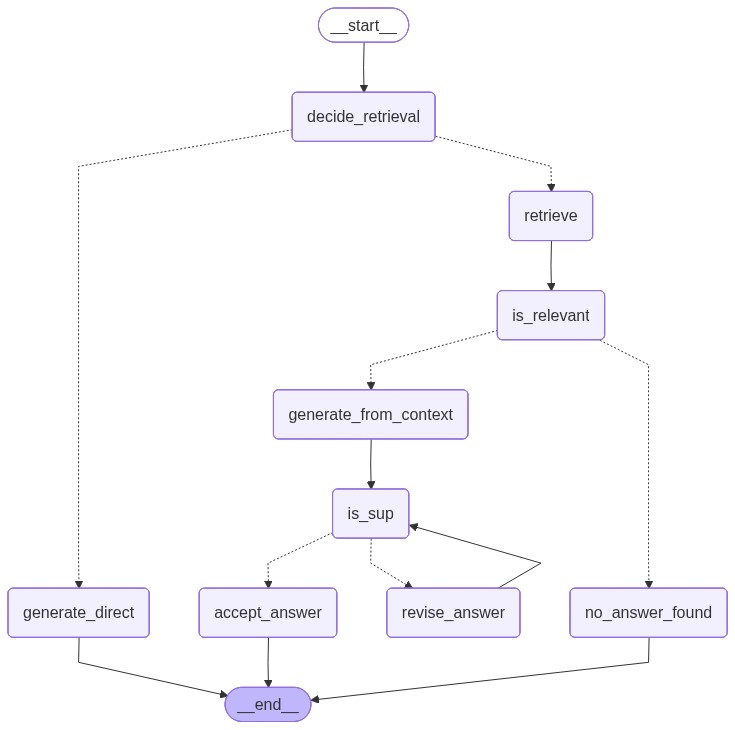

In [92]:
# -----------------------------
# Build graph (REVISED: add accept/revise + loop back to is_sup)
# -----------------------------
g = StateGraph(STATE)

g.add_node("decide_retrieval", decision_node)
g.add_node("generate_direct", direct_generate)
g.add_node("retrieve", retriever_node)

g.add_node("is_relevant", is_relevence)
g.add_node("generate_from_context", relevent_generation)
g.add_node("no_answer_found", no_relevent_docs)

g.add_node("is_sup", IsSUPOrNot)

# ✅ NEW nodes
g.add_node("accept_answer", accept_answer)
g.add_node("revise_answer", revised_node)

# --------------------
# Edges
# --------------------
g.add_edge(START, "decide_retrieval")

g.add_conditional_edges(
    "decide_retrieval",
    route_after_decision,
    {"generate_direct": "generate_direct", "retrieve": "retrieve"},
)

g.add_edge("generate_direct", END)

g.add_edge("retrieve", "is_relevant")

g.add_conditional_edges(
    "is_relevant",
    route_after_relevence,
    {"generate_from_context": "generate_from_context", "no_answer_found": "no_answer_found"},
)

# If no answer found, end
g.add_edge("no_answer_found", END)

# --------------------
# Verify → (accept | revise) → verify loop
# --------------------
g.add_edge("generate_from_context", "is_sup")

g.add_conditional_edges(
    "is_sup",
    route_after_issup,  # fully_supported -> accept_answer else revise_answer
    {"accept_answer": "accept_answer", "revise_answer": "revise_answer"},
)

g.add_edge("revise_answer", "is_sup")  # 🔁 loop back to verify
g.add_edge("accept_answer", END)

app = g.compile()
app

In [93]:
gra.invoke({'question': 'what about deep learning'})

{'question': 'what about deep learning',
 'retrieve_or_not': False,
 'answer': 'Deep learning is a subset of machine learning, which is a part of artificial intelligence (AI). It involves the use of artificial neural networks to analyze and interpret data. These neural networks are designed to mimic the human brain, with layers of interconnected nodes (neurons) that process and transmit information.\n\nDeep learning has several key features that distinguish it from other types of machine learning:\n\n1. **Multiple layers**: Deep learning models have many layers, which allow them to learn complex patterns in data. Each layer can learn to recognize different features, such as edges, textures, or objects.\n2. **Neural networks**: Deep learning models use neural networks, which are composed of nodes (neurons) that process and transmit information. These nodes are connected by edges, which represent the strength of the connections between them.\n3. **Training**: Deep learning models are tra

In [ ]:
result = gra.invoke({'question': 'CEO and manager name of karavan?'})

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01kddxezsxf04b4m36921sb5b6` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 99751, Requested 701. Please try again in 6m30.527999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
result

{'question': 'manager name of karavan?',
 'retrieve_or_not': True,
 'docs': [Document(id='60ae8109-280a-44ad-83ba-4a0c40b2d4e2', metadata={'producer': 'ReportLab PDF Library - (opensource)', 'creator': '(unspecified)', 'creationdate': '2026-02-21T10:38:35+00:00', 'author': '(anonymous)', 'keywords': '', 'moddate': '2026-02-21T10:38:35+00:00', 'subject': '(unspecified)', 'title': '(anonymous)', 'trapped': '/False', 'source': 'A:\\AI_Projects_Practice\\Self-RAG\\KaravanTech_Company_Profile.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='KaravanTech Solutions\nCompany Profile\nCompany Overview\nKaravanTech Solutions Pvt. Ltd. is a Karachi-based technology company founded in 2019, specializing in\nsoftware development, cloud infrastructure, and digital transformation services for enterprises across\nPakistan and the broader South Asian region. With a growing team of over 120 professionals,\nKaravanTech partners with organizations in banking, retail, logistics, and publ

In [73]:
result

{'question': 'how many employes work in karavan?',
 'retrieve_or_not': True,
 'docs': [Document(id='60ae8109-280a-44ad-83ba-4a0c40b2d4e2', metadata={'producer': 'ReportLab PDF Library - (opensource)', 'creator': '(unspecified)', 'creationdate': '2026-02-21T10:38:35+00:00', 'author': '(anonymous)', 'keywords': '', 'moddate': '2026-02-21T10:38:35+00:00', 'subject': '(unspecified)', 'title': '(anonymous)', 'trapped': '/False', 'source': 'A:\\AI_Projects_Practice\\Self-RAG\\KaravanTech_Company_Profile.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='KaravanTech Solutions\nCompany Profile\nCompany Overview\nKaravanTech Solutions Pvt. Ltd. is a Karachi-based technology company founded in 2019, specializing in\nsoftware development, cloud infrastructure, and digital transformation services for enterprises across\nPakistan and the broader South Asian region. With a growing team of over 120 professionals,\nKaravanTech partners with organizations in banking, retail, logistics

In [74]:
print(result['answer'])

KaravanTech Solutions has a growing team of over 120 professionals.


In [49]:
# for i in result['docs']:
#     print(i.page_content)
#     print('=-'*60)

In [50]:
# result['retrieve_or_not']

In [51]:
# for i in result['relevence_docs']:
#     print(i.page_content)